In [21]:
import pandas_datareader as wb
from pandas_datareader import data
import yfinance as yf
import requests 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from lxml import html
import datetime
from datetime import datetime
import statsmodels.api as sm
from scipy.stats import norm
from tqdm.notebook import tqdm
import os

In [18]:
def get_treasury_rate():
    
    url = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield'
    r = requests.get(url)
    html = r.text

    soup = BeautifulSoup(html)
    table = soup.find('table', {"class": "t-chart"})
    rows = table.find_all('tr')
    data = []
    for row in rows[1:]:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele])

        result = pd.DataFrame(data, columns=['Date', '1 Mo', '2 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr'])

    return(result)



def return_df(close_price_df):
        
    return_df = close_price_df.pct_change().apply(lambda x: np.log(1+x))
    
    return return_df


def port_simulation(stock_closed_df, freq = "D"):
    
    days_per_freq = {"D": 1, "W": 5, "M": 21, "Y": 250}
    
    pct_change_df = stock_closed_df.pct_change()
    period_pct_change = pct_change_df.resample(freq).mean()
    ind_er = period_pct_change.mean()
    return_df = pct_change_df.apply(lambda x: np.log(1+x))
    cov_matrix = return_df.cov()
    
    p_ret = [] 
    p_vol = [] 
    p_weights = [] 
    
    
    num_assets = len(stock_closed_df.columns)
    num_portfolios = 10000

    
    for portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights = weights/np.sum(weights)
        p_weights.append(weights)
        returns = np.dot(weights, ind_er)  
        p_ret.append(returns)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
        sd = np.sqrt(var) 
        freq_sd = sd*np.sqrt(days_per_freq[freq]) 
        p_vol.append(freq_sd)
    
    data = {'Returns':p_ret, 'Volatility':p_vol}
 
    for counter, symbol in enumerate(stock_closed_df.columns.tolist()):
        data[symbol+' weight'] = [w[counter] for w in p_weights]
        portfolios  = pd.DataFrame(data)
        
    return portfolios



In [121]:
def FF_assign_label(index_comp_info):
        
        
    index_comp_info["bookToMarket"] = 1/index_comp_info["PB_ratio"]
    index_comp_info["Small_Big_Cap"] = index_comp_info["mkt_cap"].map(lambda x: "B" if x >= index_comp_info["mkt_cap"].median() else "S")
    
    lower, upper = index_comp_info["bookToMarket"].quantile([0.3, 0.7])
    index_comp_info["HML_BP"] = index_comp_info["bookToMarket"].map(lambda x: "H" if x >= upper else "M")
    index_comp_info["HML_BP"] = index_comp_info.apply(lambda row: "L" if row["bookToMarket"] <= lower else row["HML_BP"], axis = 1)
    
    lower_roe, upper_roe = index_comp_info["ROE"].quantile([0.3, 0.7])
    index_comp_info["RNW_ROE"] = index_comp_info["ROE"].map(lambda x: "R" if x >= upper_roe else "N")
    index_comp_info["RNW_ROE"] = index_comp_info.apply(lambda row: "W" if row["ROE"] <= lower_roe else row["RNW_ROE"], axis = 1)
    
    lower_invest, upper_invest = index_comp_info["Asset_growth"].quantile([0.3, 0.7])
    index_comp_info["ANC_investment"] = index_comp_info["Asset_growth"].map(lambda x: "A" if x >= upper_invest else "N")
    index_comp_info["ANC_investment"] = index_comp_info.apply(lambda row: "C" if row["Asset_growth"] <= lower_invest else row["ANC_investment"], axis = 1)
            
    return index_comp_info
        
def FF_factor_classifier(index_comp_info_with_label):
        
    data = index_comp_info_with_label
    Small_Low = data.query('(Small_Big_Cap=="S") & (HML_BP=="L")')
    Small_Mid = data.query('(Small_Big_Cap=="S") & (HML_BP=="M")')
    Small_High = data.query('(Small_Big_Cap=="S") & (HML_BP=="H")')
    
    Small_Weak = data.query('(Small_Big_Cap=="S") & (RNW_ROE=="W")')
    Small_Neutral_Profit = data.query('(Small_Big_Cap=="S") & (RNW_ROE=="N")')
    Small_Robust = data.query('(Small_Big_Cap=="S") & (RNW_ROE=="R")')
    
    Small_Conservative =  data.query('(Small_Big_Cap=="S") & (ANC_investment=="C")')
    Small_Neutral_Invest =  data.query('(Small_Big_Cap=="S") & (ANC_investment=="N")')
    Small_Aggresive =  data.query('(Small_Big_Cap=="S") & (ANC_investment=="A")')
    
    Big_Low = data.query('(Small_Big_Cap=="B") & (HML_BP=="L")')
    Big_Mid = data.query('(Small_Big_Cap=="B") & (HML_BP=="M")')
    Big_High = data.query('(Small_Big_Cap=="B") & (HML_BP=="H")')
    
    Big_Weak = data.query('(Small_Big_Cap=="B") & (RNW_ROE=="W")')
    Big_Neutral_Profit = data.query('(Small_Big_Cap=="B") & (RNW_ROE=="N")')
    Big_Robust = data.query('(Small_Big_Cap=="B") & (RNW_ROE=="R")')

    Big_Conservative =  data.query('(Small_Big_Cap=="B") & (ANC_investment=="C")')
    Big_Neutral_Invest = data.query('(Small_Big_Cap=="B") & (ANC_investment=="N")')
    Big_Aggresive =  data.query('(Small_Big_Cap=="B") & (ANC_investment=="A")')
    
    each_groups_list = [Small_Low, Small_Mid, Small_High, 
                            Small_Weak, Small_Neutral_Profit, Small_Robust,
                            Small_Conservative, Small_Neutral_Invest, Small_Aggresive,
                            Big_Low, Big_Mid,Big_High,
                            Big_Weak, Big_Neutral_Profit, Big_Robust,
                            Big_Conservative, Big_Neutral_Invest, Big_Aggresive]
        
    return each_groups_list
    
def FF_classes_return(market_components_return, list_of_group_info, axis=True):
        
    groups_names = ["Small_Low", "Small_Mid", "Small_High",
                        "Small_Weak", "Small_Neutral_Profit", "Small_Robust",
                        "Small_Cons", "Small_Neutral_Invest", "Small_Aggr",
                        "Big_Low", "Big_Mid","Big_High",
                        "Big_Weak", "Big_Neutral_Profit", "Big_Robust",
                        "Big_Cons", "Big_Neutral_Invest", "Big_Aggr"]
    
    df_groups = pd.DataFrame(columns = groups_names)
    
    counter = 0
    
    for group in list_of_group_info:
    
        group_cap = group["mkt_cap"].T
        group_total_cap = group["mkt_cap"].sum()
        group_cap_multi_return = group_cap*market_components_return[list(group.index)]
        
        if axis == True:
            df_groups[groups_names[counter]] = group_cap_multi_return.apply(lambda row: row.sum()/group_total_cap, axis=1)
        
        else:
            groups_index_return = group_cap_multi_return.sum()/group_total_cap
            df_groups[groups_names[counter]] = [groups_index_return]
    
        counter += 1
                
    return df_groups
    
def FF_calc_factors(classes_return_df, df = True):
    
    factor_name = ["SMB", "HML", "RMW", "CMA"]
    
    SMB_BP = (classes_return_df["Small_Low"] + classes_return_df["Small_Mid"] 
                      + classes_return_df["Small_High"]) - (classes_return_df["Big_Low"]
                      + classes_return_df["Big_Mid"] + classes_return_df["Big_High"])/3
    
    SMB_PFT = (classes_return_df["Small_Weak"] + classes_return_df["Small_Neutral_Profit"] 
                      + classes_return_df["Small_Robust"]) - (classes_return_df["Big_Weak"]
                      + classes_return_df["Big_Neutral_Profit"] + classes_return_df["Big_Robust"])/3
    
    SMB_INV = (classes_return_df["Small_Cons"] + classes_return_df["Small_Neutral_Invest"] 
                      + classes_return_df["Small_Aggr"]) - (classes_return_df["Big_Cons"]
                      + classes_return_df["Big_Neutral_Invest"] + classes_return_df["Big_Aggr"])/3
    
    if df == True:
        
        FF_factors_data = pd.DataFrame(columns = factor_name)
        
    
    FF_factors_data["SMB"] = (SMB_BP + SMB_PFT + SMB_INV)/3
    
    FF_factors_data["HML"] = (classes_return_df["Small_High"] + classes_return_df["Big_High"]
                      - (classes_return_df["Small_Low"] + classes_return_df["Big_Low"])) / 2
    
    FF_factors_data["RMW"] = (classes_return_df["Small_Robust"] + classes_return_df["Big_Robust"]
                      - (classes_return_df["Small_Weak"] + classes_return_df["Big_Weak"])) / 2
    
    FF_factors_data["CMA"] = (classes_return_df["Small_Cons"] + classes_return_df["Big_Cons"]
                      - (classes_return_df["Small_Aggr"] + classes_return_df["Big_Aggr"])) / 2
        
    return FF_factors_data

    
def FF_regress(FF_factors_df, target_comp_risk_premium):
            
    y = target_comp_risk_premium
    x = FF_factors_df
    X = sm.add_constant(x)
    model = sm.OLS(y.astype(float), X.astype(float))
    result = model.fit()
 
    print(result.summary())
    print('\n\n')

    
    return result
    
        
    

Frequency: 30 min and 2 min

Time series Beta estimation: Measure 5 betas for each 30 min, using 2 min frequency. (Need to know how betas change every 30 min)

Plan B:
1) Use historical return data (2m or higher frequency) of 505 companies in SP500 index to run FF for each company.
2) Calculate probability of beating market in certain period (if APPL 2m Sharpe beated the market 5 times in last 30 min, prob of beating is 5/15 = 0.333).
3) put 1) and 2) together to get a all companies' prob of winning in given period and their Betas.
4) Model probability from 3)
5) Caculate Betas for all 10,000 simulated potfolio
6) get the probability of winning

How to make it predictive?

Model Construction: This may not work

1) model the probability of 30 min winning with 5 betas(5 features) we eatimate every 30 min. (can use SVM, decision tree, regression...)

2) measure betas of winner-loser portfolios spread for same time length for our portolios

3) plug betas of portfolios to the model in 1)

4) model true prob of winning of portfolios on fitted value from 3)

5) make analyical model to preidictive model

The reason we estimate the probability of picking a winner portfolio with given beta is because as we move from Time(T) T1 to T2, the stock price changes, so our weight also changes. We are essensially move from one simulated portfolio to another simulated portfolio as the time goes.


What ML can apply here?

What would the result be if use unsupervised grouping to caculate factors? (Maybe useful when FF doesn't explain well in term of R^2)

Any potential non-linear relationship?

How to optimize time scale to ensure the highest predictive ability? or would models' ability consistant accross time series mapping?

How to test predictivity?

Any trade off between high winning prob and portfolio sharpe?

# Data Collection

In [24]:
print(os.getcwd())
print(os.listdir(os.getcwd()))

/Users/liuhengjia/Desktop/css100_project
['CSS100.ipynb', '.DS_Store', '.ipynb_checkpoints']


In [28]:
os.chdir("/Users/liuhengjia/Desktop")

In [29]:
FF_info = pd.read_csv("data/Fama_French_info.csv", index_col = 0)

In [8]:
str1 = ' '
index_list = FF_info.index.tolist()
index_list.append("SPY")
#index_list.reverse()
total_string = str1.join(index_list)

In [169]:
#SPYn500_30m_df = yf.download(total_string, start = '2021-10-11', end = "2021-11-18", interval = '30m')
#SPYn500_2m_df = yf.download(total_string, start = '2021-10-11', end = "2021-11-18", interval = '2m')

In [53]:
#SPYn500_30m_df["Adj Close"].to_csv("SPYn500_30m_close.csv")
#SPYn500_2m_df["Adj Close"].to_csv("SPYn500_2m_close.csv")

In [30]:
sp_2m_close = pd.read_csv("data/SPYn500_2m_close.csv", index_col = 0)
sp_30m_close = pd.read_csv("data/SPYn500_30m_close.csv", index_col = 0)

In [31]:
sp_2m_close.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-10-11 09:30:00-04:00,150.729996,20.120001,214.000000,141.949997,111.199997,120.519997,333.580200,118.260002,324.829987,571.551025,...,61.740002,154.020004,62.622299,58.139999,121.169998,123.730003,146.309998,492.000000,64.209999,196.289993
2021-10-11 09:32:00-04:00,150.690002,20.020000,213.889999,142.850006,111.160004,121.260002,333.104889,118.154999,325.119995,574.900024,...,62.064999,155.339996,62.560001,58.119999,121.239998,123.787201,146.315002,NaN,63.900002,196.509995
2021-10-11 09:34:00-04:00,151.330002,19.870001,214.000000,142.889999,111.129997,121.184998,335.989990,118.599998,324.910004,575.900024,...,62.360001,155.895004,62.556599,58.000000,120.980003,123.180000,NaN,NaN,63.650002,196.820007
2021-10-11 09:36:00-04:00,150.720001,19.925501,213.960007,142.619995,111.165001,121.589996,NaN,118.139999,324.929993,574.859985,...,62.310001,156.000000,62.770000,57.939999,121.135002,123.209999,146.500000,493.440002,63.750000,196.669998
2021-10-11 09:38:00-04:00,151.080002,19.940001,213.809998,143.059998,110.995003,121.919998,NaN,118.010002,325.589996,575.750000,...,62.139999,156.729996,62.509499,58.049000,121.269997,123.379997,146.690002,494.079987,63.680000,196.770004


# Calculate log-return (assuming return is log-normal) for both time interval

In [32]:
total_2m_return = return_df(sp_2m_close)
total_30m_return = return_df(sp_30m_close)

In [ ]:
total_2m_return = total_2m_return.dropna(how = "all")

In [33]:
sp500_2m_return = total_2m_return.drop(columns=["SPY"]).dropna(how="all")
sp500_2m_volatility = sp500_2m_return.std()
sp500_30m_return = total_30m_return.drop(columns=["SPY"]).dropna(how="all")
sp500_30m_volatility = sp500_30m_return.std()

In [12]:
#sp500_2m_return = sp500_2m_return.drop(columns = list(FF_info[FF_info["mkt_cap"].isna()].index))

In [115]:
Rm_30m = total_30m_return[['SPY']]
Rm_2m = total_2m_return[['SPY']]
Rm_2m = Rm_2m.dropna(how="all")
#We need to discount Monthly Rf to 2m and 30m Rf using yield curve(continuously compounded)
Rf = 0

In [35]:
market_2m_sharpe = (Rm_2m - Rf)/Rm_2m.std()
market_2m_sharpe = market_2m_sharpe.dropna()
market_30m_sharpe = (Rm_30m - Rf)/Rm_30m.std()
market_30m_sharpe = market_30m_sharpe.dropna()

In [36]:
sp500_2m_sharpe = (sp500_2m_return - Rf)/sp500_2m_volatility
sp500_30m_sharpe = (sp500_30m_return - Rf)/sp500_30m_volatility

In [37]:
#the index columns doesn't match for some reasons, need to fix !
sp500_2m_sharpe_excess = sp500_2m_sharpe.subtract(market_2m_sharpe.values, axis=0)
sp500_30m_sharpe_excess = sp500_30m_sharpe.subtract(market_30m_sharpe.values, axis=0)

# Modeling spread between winner return and loser return on FF5F

## Feature Engineering

### Calculate FF factors for lower freq

In [112]:
FF_info_labeled = FF_assign_label(FF_info)
FF_classified_list = FF_factor_classifier(FF_info_labeled)
FF_2m_classes_return = FF_classes_return(sp500_2m_return,FF_classified_list)
FF_2m_factor = FF_calc_factors(FF_2m_classes_return)

In [117]:
FF_2m_factor["Rm-Rf"] = Rm_2m - Rf

In [118]:
FF_2m_factor.head()

,SMB,HML,RMW,CMA,Rm-Rf
Datetime,,,,,
2021-10-11 09:32:00-04:00,-0.001462,-0.003179,0.001835,-0.000872,0.001504
2021-10-11 09:34:00-04:00,-0.005193,-0.002111,0.001227,-0.000469,-0.001024
2021-10-11 09:36:00-04:00,0.004055,0.001614,-0.001921,0.001213,0.000137
2021-10-11 09:38:00-04:00,-0.002212,-0.001802,0.001485,-0.001496,0.000412
2021-10-11 09:40:00-04:00,0.001367,0.000242,-0.000396,-0.000521,0.000800


In [38]:
dummies_2m_beaters = sp500_2m_sharpe_excess.copy()
dummies_2m_beaters[dummies_2m_beaters >= 0] =1
dummies_2m_beaters[dummies_2m_beaters < 0] =0

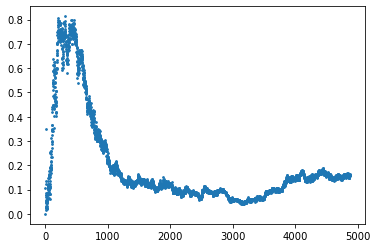

In [107]:
c = 505
time_length = range(len(dummies_2m_beaters.index))
winner_rate_list = []
for length in tqdm(time_length):
    winner_rate = len(dummies_2m_beaters.iloc[:length].mean()[dummies_2m_beaters.iloc[:length].mean()>0.5])/c
    winner_rate_list.append(winner_rate)
    
plt.scatter(time_length, winner_rate_list, s=3)

In [110]:
sp500_2m_return = total_2m_return.dropna(how = "all")

In [125]:
FF_regress(FF_2m_factor, sp500_2m_return["AAPL"])

                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     1244.
Date:                Sat, 27 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:19:24   Log-Likelihood:                 29929.
No. Observations:                4874   AIC:                        -5.985e+04
Df Residuals:                    4868   BIC:                        -5.981e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.826e-06   7.48e-06      0.244      0.8

In [108]:
dummies_2m_beaters

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-10-11 09:32:00-04:00,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-11 09:34:00-04:00,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
2021-10-11 09:36:00-04:00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
2021-10-11 09:38:00-04:00,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2021-10-11 09:40:00-04:00,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-17 15:50:00-05:00,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2021-11-17 15:52:00-05:00,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2021-11-17 15:54:00-05:00,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [46]:
WML["Rm-Rf"] = Rm_Rf_test

In [48]:
#WML.to_csv("winner_loser_spread_data.csv")
WML = pd.read_csv("data/winner_loser_spread_data.csv", index_col = 0)
WML["Rm-Rf"] = Rm_Rf_test

In [55]:
WML_test = WML.fillna(0)

In [66]:
WML_test

,winner_return,loser_return,R_WML,SMB_WML,HML_WML,RMW_WML,CMA_WML,Rm-Rf
Datetime,,,,,,,,
2021-10-11 09:32:00-04:00,0.005410,0.000192,0.005218,0.013753,0.001752,-0.001094,0.001791,0.001504
2021-10-11 09:34:00-04:00,0.000137,-0.004206,0.004343,0.010615,-0.001710,0.000199,-0.000463,-0.001024
2021-10-11 09:36:00-04:00,0.002140,-0.001644,0.003785,0.009454,-0.000403,-0.000388,0.001155,0.000137
2021-10-11 09:38:00-04:00,0.002154,-0.000701,0.002855,0.009562,-0.000324,-0.000832,0.001345,0.000412
2021-10-11 09:40:00-04:00,0.002637,0.000114,0.002524,0.008173,-0.001392,-0.000229,0.000156,0.000800
...,...,...,...,...,...,...,...,...
2021-11-17 15:50:00-05:00,0.000512,-0.000807,0.001319,0.003193,0.000022,-0.000082,0.000252,-0.000085
2021-11-17 15:52:00-05:00,0.000227,-0.000608,0.000834,0.001933,-0.000088,-0.000041,-0.000199,-0.000085
2021-11-17 15:54:00-05:00,-0.000126,-0.001534,0.001408,0.003027,-0.000439,-0.000225,0.000615,-0.000406


In [65]:
FF_regress(WML_test[["SMB_WML","HML_WML", "RMW_WML", "CMA_WML"]].iloc[4000:], WML_test[["R_WML"]].iloc[4000:], Rf)

                            OLS Regression Results                            
Dep. Variable:                  R_WML   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     547.0
Date:                Thu, 25 Nov 2021   Prob (F-statistic):          1.38e-235
Time:                        20:01:40   Log-Likelihood:                 5473.8
No. Observations:                 874   AIC:                        -1.094e+04
Df Residuals:                     869   BIC:                        -1.091e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   2.92e-05      5.353      0.0

## Feature Engineering

In [40]:
dummies_30m_beaters = sp500_30m_sharpe_excess.copy()
dummies_30m_beaters[dummies_30m_beaters >= 0] =1
dummies_30m_beaters[dummies_30m_beaters < 0] =0

In [174]:
#This is the prob of 15 min winning
dummies_30m_beaters.T.mean()

Datetime
2021-10-11 10:00:00-04:00    0.154455
2021-10-11 10:30:00-04:00    0.803960
2021-10-11 11:00:00-04:00    0.594059
2021-10-11 11:30:00-04:00    0.398020
2021-10-11 12:00:00-04:00    0.906931
                               ...   
2021-11-17 13:30:00-05:00    0.201980
2021-11-17 14:00:00-05:00    0.831683
2021-11-17 14:30:00-05:00    0.295050
2021-11-17 15:00:00-05:00    0.758416
2021-11-17 15:30:00-05:00    0.762376
Length: 363, dtype: float64

In [164]:
#slice 2m spread data by 15 rows, and measure beta for each 15 rows (15 mins)

In [ ]:
#combine betas measured above with 15 min prob of beating

In [165]:
#Regress prob of beating on observed betas